In [0]:
###############################
#                             #
#        ENCODE FACTORS       #
#                             #
###############################

# performs label encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
def label_encoding(df_train, df_valid, df_test):
    
    factors = df_train.select_dtypes('object').columns
    
    lbl = LabelEncoder()

    for f in factors:        
        lbl.fit(list(df_train[f].values) + list(df_valid[f].values) + list(df_test[f].values))
        df_train[f] = lbl.transform(list(df_train[f].values))
        df_valid[f] = lbl.transform(list(df_valid[f].values))
        df_test[f]  = lbl.transform(list(df_test[f].values))

    return df_train, df_valid, df_test

def one_hot_encoding(df_train, df_valid, df_test):

    factors = df_train.select_dtypes('object').columns

    lbl = OneHotEncoder()

    for f in factors:        
        lbl.fit(list(df_train[f].values) + list(df_valid[f].values) + list(df_test[f].values))
        df_train[f] = lbl.transform(list(df_train[f].values))
        df_valid[f] = lbl.transform(list(df_valid[f].values))
        df_test[f]  = lbl.transform(list(df_test[f].values))

    return df_train, df_valid, df_test

import numpy as np
def reduce_mem_usage(df, verbose = True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [40]:
# GOOGLE COLAB SETUP

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import os
os.chdir('drive/My Drive/Colab Notebooks/WIDS/WIDS/')

FileNotFoundError: ignored

In [0]:

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')
%matplotlib inline

import os
import time
import datetime
import random
import multiprocessing
import pickle

import scipy.stats

import gc
gc.enable()

import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import log_loss, roc_auc_score, confusion_matrix

import lightgbm as lgb

In [0]:
import sys
sys.path.append('drive/My Drive/Colab Notebooks/WIDS/WIDS/codes')

In [0]:
############ RANDOMNESS

# seed function
def seed_everything(seed = 42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    
# set seed
seed = 42
seed_everything(seed)

### IMPORT

In [118]:
############ DATA IMPORT

# id data
train = pd.read_csv('./raw/training_v2.csv')
test  = pd.read_csv('./raw/unlabeled.csv')


# check dimensions
print(train.shape)
print(train.shape)

train = train[-train['hospital_death'].isnull()]

(91713, 186)
(91713, 186)


In [0]:
#train = reduce_mem_usage(train)
#test  = reduce_mem_usage(test)

In [120]:
train.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,1

In [0]:
#pd.DataFrame(train.isnull().sum())

In [0]:
#X = pd.concat([train, test], axis=0)
#X = pd.get_dummies(X)

# Remove Features with more than 80 percent missing values
#train_missing = (X.isnull().sum() / len(X)).sort_values(ascending = False)
#train_missing = train_missing.index[train_missing > 0.8]
#X = X.drop(columns = train_missing)

#train = X[-X['hospital_death'].isnull()]
#test  = X[X['hospital_death'].isnull()]

In [0]:
y     = train['hospital_death']
train = train.drop('hospital_death', axis=1)

In [0]:
############ FEAUTERS

# drop bad features
excluded_feats = ['encounter_id', 'patient_id', 'readmission_status', 'hospital_id', 'icu_id']

In [0]:
train['hospital_id'] = train['hospital_id'].astype('object')
test['hospital_id']  = test['hospital_id'].astype('object')

In [0]:
#train['conditions'] = train[['aids','cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma','solid_tumor_with_metastasis']].sum(axis=1)
#test['conditions'] = test[['aids','cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma','solid_tumor_with_metastasis']].sum(axis=1)

In [0]:
train['d1_diasbp_span'] = train['d1_diasbp_max'] - train['d1_diasbp_min']
test['d1_diasbp_span']  = test['d1_diasbp_max'] - test['d1_diasbp_min']

train['d1_diasbp_invasive_span'] = train['d1_diasbp_invasive_max'] - train['d1_diasbp_invasive_min']
test['d1_diasbp_invasive_span']  = test['d1_diasbp_invasive_max'] - test['d1_diasbp_invasive_min']

train['d1_diasbp_noninvasive_span'] = train['d1_diasbp_noninvasive_max'] - train['d1_diasbp_noninvasive_min']
test['d1_diasbp_noninvasive_span']  = test['d1_diasbp_noninvasive_max'] - test['d1_diasbp_noninvasive_min']

train['d1_heartrate_span'] = train['d1_heartrate_max'] - train['d1_heartrate_min']
test['d1_heartrate_span']  = test['d1_heartrate_max'] - test['d1_heartrate_min']

In [0]:
#train['apache_prob_sum'] = train[['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']].sum(axis=1)
#test['apache_prob_sum']  = test[['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']].sum(axis=1)

train['apache_prob_prod'] = train['apache_4a_hospital_death_prob'] * train[ 'apache_4a_icu_death_prob']
test['apache_prob_prod'] = test['apache_4a_hospital_death_prob'] * train[ 'apache_4a_icu_death_prob']

In [129]:
features = [f for f in train.columns if f not in excluded_feats]
#features = ['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']
print(train[features].shape)

(91713, 185)


In [0]:

############ PARAMETERS

# cores
cores = -1
# cross-validation
num_folds = 15
shuffle   = True

# number of trees
max_rounds = 10000
stopping   = 600
verbose    = 250

# LGB parameters
lgb_params = {
    'boosting_type':     'gbdt',
    'objective':         'binary',
    'metric':            'auc',
    'bagging_fraction':  0.9,
    'feature_fraction':  0.9,
    'lambda_l1':         0.1,
    'lambda_l2':         0.1,
    'min_split_gain':    0,
    'min_child_weight':  0.1,
    'min_child_samples': 10,
    'silent':            True,
    'verbosity':         -1,
    'learning_rate':     0.01,
    'max_depth':         5,
    'num_leaves':        64,
    'scale_pos_weight':  1,
    'n_estimators':      max_rounds,
    'nthread' :          cores,
    'random_state':      seed,
    #"device" : "gpu"
}

# data partitinoing
folds = StratifiedKFold(n_splits = num_folds, random_state = seed, shuffle = shuffle)
#folds = GroupKFold(n_splits = num_folds)
#folds = model_selection.TimeSeriesSplit(n_splits = 10)

# SMOTE settings
#from imblearn.over_sampling import SMOTE
#sm = SMOTE(random_state = seed, n_jobs = cores, sampling_strategy = 0.05)

In [0]:

############ PLACEHOLDERS

# placeholders
clfs = []
importances = pd.DataFrame()

# predictions
preds_test   = np.zeros(test.shape[0])
preds_oof    = np.zeros(train.shape[0])

In [132]:
############ CROSS-VALIDATION LOOP
cv_start  = time.time()
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train, y)):

    # data partitioning
    trn_x, trn_y = train[features].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = train[features].iloc[val_idx], y.iloc[val_idx]
    test_x       = test[features]
    
    ## augment training data with SMOTE
    #trn_x[trn_x.columns]  = trn_x[trn_x.columns].apply(pd.to_numeric,   errors = 'coerce')
    #val_x[val_x.columns]  = val_x[val_x.columns].apply(pd.to_numeric,   errors = 'coerce')
    #test_x[val_x.columns] = test_x[test_x.columns].apply(pd.to_numeric, errors = 'coerce')
    #trn_x  = trn_x.replace([np.inf,  -np.inf], np.nan)
    #val_x  = val_x.replace([np.inf,  -np.inf], np.nan)
    #test_x = test_x.replace([np.inf, -np.inf], np.nan)
    #trn_x  = trn_x.fillna(trn_x.median())
    #val_x  = val_x.fillna(val_x.median())
    #test_x = test_x.fillna(test_x.median())
    #trn_x, trn_y = sm.fit_sample(trn_x, trn_y)
    #trn_x = pd.DataFrame(trn_x, columns = features)
    #trn_y = pd.Series(trn_y)
    
    #trn_x  = trn_x.fillna(-999)
    #val_x  = val_x.fillna(-999)
    #test_x = test_x.fillna(-999)

    # Aggregate data
    '''agg_features = list(trn_x.select_dtypes('number').columns)
    aggregated = list(trn_x.select_dtypes('object').columns)
    for variable in aggregated:
        print(f'preparing {variable}')
        agg_features.append(variable)
        features_ = trn_x[agg_features].groupby(variable).mean()
        features_.columns = [f'{variable}_{column}_mean' for column in features_.columns]
        trn_x  = trn_x.merge(features_, left_on=variable, right_on=variable, how='left')
        val_x  = val_x.merge(features_, left_on=variable, right_on=variable, how='left')
        test_x = test_x.merge(features_, left_on=variable, right_on=variable, how='left')
        agg_features.remove(variable)'''
        
    '''for variable in aggregated:
        print(f'preparing {variable}')
        agg_features.append(variable)
        features_ = trn_x[agg_features].groupby(variable).sum()
        features_.columns = [f'{variable}_{column}_sum' for column in features_.columns]
        trn_x  = trn_x.merge(features_, left_on=variable, right_on=variable, how='left')
        val_x  = val_x.merge(features_, left_on=variable, right_on=variable, how='left')
        test_x = test_x.merge(features_, left_on=variable, right_on=variable, how='left')
        agg_features.remove(variable)
    
    for variable in aggregated:
        print(f'preparing {variable}')
        agg_features.append(variable)
        features_ = trn_x[agg_features].groupby(variable).std()
        features_.columns = [f'{variable}_{column}_std' for column in features_.columns]
        trn_x  = trn_x.merge(features_, left_on=variable, right_on=variable, how='left')
        val_x  = val_x.merge(features_, left_on=variable, right_on=variable, how='left')
        test_x = test_x.merge(features_, left_on=variable, right_on=variable, how='left')
        agg_features.remove(variable)'''
        
        
    # Fill Na
    trn_x['weight']  = trn_x['weight'].fillna(trn_x.groupby(['ethnicity','age','gender'])['weight'].transform('mean'))
    val_x['weight']  = val_x['weight'].fillna(trn_x.groupby(['ethnicity','age','gender'])['weight'].transform('mean'))
    test_x['weight'] = test_x['weight'].fillna(trn_x.groupby(['ethnicity','age','gender'])['weight'].transform('mean'))
    
    trn_x['height']  = trn_x['height'].fillna(trn_x.groupby(['ethnicity','age','gender'])['height'].transform('mean'))
    val_x['height']  = val_x['height'].fillna(trn_x.groupby(['ethnicity','age','gender'])['height'].transform('mean'))
    test_x['height'] = test_x['height'].fillna(trn_x.groupby(['ethnicity','age','gender'])['height'].transform('mean'))
    
    trn_x['bmi']  = trn_x['bmi'].fillna(trn_x.groupby(['ethnicity','age','gender'])['bmi'].transform('mean'))
    val_x['bmi']  = val_x['bmi'].fillna(trn_x.groupby(['ethnicity','age','gender'])['bmi'].transform('mean'))
    test_x['bmi'] = test_x['bmi'].fillna(trn_x.groupby(['ethnicity','age','gender'])['bmi'].transform('mean'))
    
    for column in trn_x.select_dtypes('object').columns:
        trn_x[column] = trn_x[column].fillna('')
        val_x[column] = val_x[column].fillna('')
        test_x[column] = test_x[column].fillna('')
        
    #for column in trn_x.select_dtypes('object').columns:
    #    trn_x[column] = trn_x[column].fillna(trn_x[column].mode()[0])
    #    val_x[column] = val_x[column].fillna(trn_x[column].mode()[0])
    #    test_x[column] = test_x[column].fillna(trn_x[column].mode()[0])

    # label encoding
    trn_x, val_x, test_x = label_encoding(trn_x, val_x, test_x)
    
    
    ## remove outliers
    # num_vars = trn_x.select_dtypes(include='number')
    #num_vars = num_vars.columns
    #for num_var in num_vars:
    #    trn_x[num_var] = trn_x[num_var].replace([np.inf, -np.inf], np.nan)
    #    trn_x[num_var] = trn_x[num_var].fillna(trn_x[num_var].median())
    #out_idx = (np.abs(scipy.stats.zscore(trn_x[num_vars])) < 20).all(axis = 1) + (trn_y.values == 1)
    #trn_x = trn_x[out_idx]
    
    ## scale data
    #val_x  = val_x.replace([np.inf, -np.inf], np.nan)
    
    #scaler   = RobustScaler()
    #trn_x    = pd.DataFrame(scaler.fit_transform(trn_x))
    #val_x    = pd.DataFrame(scaler.transform(val_x))
    #test_x   = pd.DataFrame(scaler.transform(test_x))
       
    ## add noise to train to reduce overfitting
    trn_x += np.random.normal(0, 0.01, trn_x.shape)
    
    # print data dimensions
    print('Data shape:', trn_x.shape, val_x.shape)
    #print('Data shape:', trn_y.shape, val_y.shape)    
    # train lightGBM
    clf = lgb.LGBMClassifier(**lgb_params) 
    clf = clf.fit(trn_x, trn_y, 
                  eval_set              = [(trn_x, trn_y), (val_x, val_y)], 
                  eval_metric           = 'auc', 
                  early_stopping_rounds = stopping,
                  verbose               = verbose)
    clfs.append(clf)
    
    # find the best iteration
    best_iter = clf.best_iteration_

    # save predictions
    preds_oof[val_idx] = clf.predict_proba(val_x,  num_iteration = best_iter)[:, 1]
    preds_test        += clf.predict_proba(test_x, num_iteration = best_iter)[:, 1] / folds.n_splits 

    # importance
    fold_importance_df               = pd.DataFrame()
    fold_importance_df['Feature']    = trn_x.columns
    fold_importance_df['Importance'] = clf.feature_importances_
    fold_importance_df['Fold']       = n_fold + 1
    importances                      = pd.concat([importances, fold_importance_df], axis = 0)
    
    # print performance
    print('--------------------------------')
    print('FOLD%2d: AUC = %.6f' % (n_fold + 1, roc_auc_score(y[val_idx], preds_oof[val_idx])))
    print('--------------------------------')
    print('')
        
    # clear memory
    del trn_x, trn_y, val_x, val_y
    gc.collect()
    
    
# print overall performance    
cv_perf = roc_auc_score(y, preds_oof)
print('--------------------------------')
print('- OOF AUC = %.6f' % cv_perf)
print('- CV TIME = {:.2f} min'.format((time.time() - cv_start) / 60))
print('--------------------------------')

Data shape: (85598, 185) (6115, 185)
Training until validation scores don't improve for 600 rounds.
[250]	training's auc: 0.907465	valid_1's auc: 0.898583
[500]	training's auc: 0.923708	valid_1's auc: 0.906575
[750]	training's auc: 0.934231	valid_1's auc: 0.90958
[1000]	training's auc: 0.942212	valid_1's auc: 0.911272
[1250]	training's auc: 0.948897	valid_1's auc: 0.912682
[1500]	training's auc: 0.954727	valid_1's auc: 0.913628
[1750]	training's auc: 0.959882	valid_1's auc: 0.914146
[2000]	training's auc: 0.964487	valid_1's auc: 0.914428
[2250]	training's auc: 0.968422	valid_1's auc: 0.914687
[2500]	training's auc: 0.971983	valid_1's auc: 0.914867
[2750]	training's auc: 0.974981	valid_1's auc: 0.914852
[3000]	training's auc: 0.977899	valid_1's auc: 0.914831
[3250]	training's auc: 0.980421	valid_1's auc: 0.914822
Early stopping, best iteration is:
[2850]	training's auc: 0.97625	valid_1's auc: 0.914934
--------------------------------
FOLD 1: AUC = 0.914934
------------------------------

### EVALUATION

In [0]:
############ RECHECK PERFORMANCE  

# check performance
print(np.round(roc_auc_score(y, preds_oof), 5))


############ TRACK RESULTS

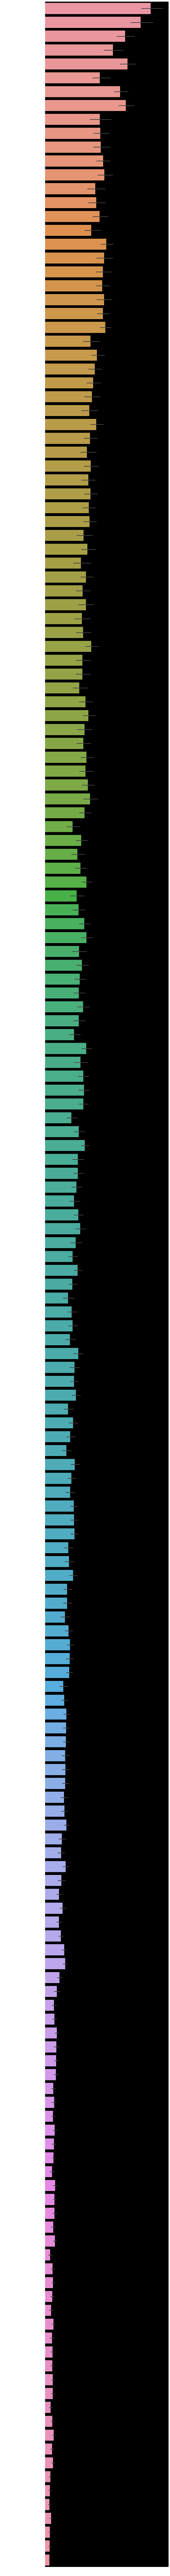

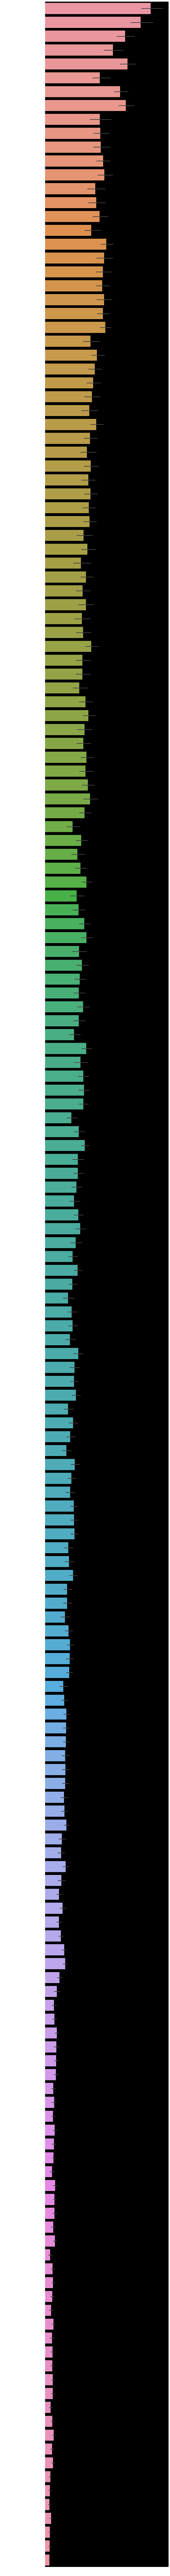

In [134]:
############ VARIABLE IMPORTANCE

# load importance    
top_feats = 300
cols = importances[['Feature', 'Importance']].groupby('Feature').mean().sort_values(by = 'Importance', ascending = False)[0:top_feats].index
importance = importances.loc[importances.Feature.isin(cols)]
    
# plot variable importance
plt.figure(figsize = (10, 150))
sns.barplot(x = 'Importance', y = 'Feature', data = importance.sort_values(by = 'Importance', ascending = False))
plt.tight_layout()
plt.savefig('../var_importance.pdf')

SUBMISSION

In [135]:
# file name
model = 'lgb_v21'
perf  = str(round(cv_perf, 6))[2:7]
name  = model + '_' + perf
name

'lgb_v21_90535'

'lgb_v21_90535'

In [136]:
# export OOF preds
oof = pd.DataFrame({'encounter_id': train['encounter_id'], 'hospital_death': preds_oof})
oof.to_csv('./oof_preds/' + str(name) + '.csv', index = False)
oof.head()

,encounter_id,hospital_death
0,66154,0.064415
1,114252,0.705658
2,119783,0.001136
3,79267,0.052539
4,92056,0.010571


,encounter_id,hospital_death
0,66154,0.064415
1,114252,0.705658
2,119783,0.001136
3,79267,0.052539
4,92056,0.010571


In [137]:

# export submission
sub = pd.DataFrame({'encounter_id': test['encounter_id'], 'hospital_death': preds_test})
sub.to_csv('./submissions/' + str(name) + '.csv', index = False)
sub.head()

,encounter_id,hospital_death
0,2,0.020096
1,5,0.026856
2,7,0.010761
3,8,0.150424
4,10,0.519403


,encounter_id,hospital_death
0,2,0.020096
1,5,0.026856
2,7,0.010761
3,8,0.150424
4,10,0.519403
